In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import re
import itertools
import pandas as pd
import time
import os

In [121]:
#Coumpound counter starts from 1
# Helper function for binary translation
def IntegerToBinaryTF(num: int, ls_bn: list)-> list:
    if num >= 2:
        ls_bn=IntegerToBinaryTF(num // 2, ls_bn)
    ls_bn.append(num % 2==1)
    return(ls_bn)


# Function to assign each compound to its wells
def well_selecter(compound: int, n_wells:int, differentiate=1) -> np.array:
    if differentiate not in [1,2]:
        print('For the moment this code is only able to create well assignments matrices to distinguish up to combinations of 2 active compounds')
        return(-1)
    if differentiate==1:
        ls_bn=[]
        used_wells=IntegerToBinaryTF(compound, ls_bn)
        sel_wells=[False]*(n_wells-len(used_wells))+used_wells
    if differentiate==2:
        for i in range((n_wells-1)//3+1):
            if 0<compound and compound <= n_wells-1-3*i:
                sel_wells=(n_wells-1-3*i-compound)*[False]+[True]+i*3*[False]+[True]+[False]*(compound-1)
                break
            compound=compound-(n_wells-1-3*i)
    return(np.array(sel_wells))
    
def get_ncomp_from_nwells(nwells: int, differentiatie=1) ->int:
    if differentiatie==1:
        return(2**nwells-1)
    if differentiatie==2:
        temp_1=((nwells-2)//3)+1
        temp_2=temp_1-1
        return(nwells*temp_1-(temp_2*(temp_2+1)/2*3+temp_1)) #Some algebra gives this formula


# Functions to be called by user to create the compound-wells assignment matrix

''' Method 1: Pooling using matrix design'''
def assign_wells_mat(n_compounds:int, **kwargs)->np.array:
    L1=np.ceil(np.sqrt(n_compounds))
    L2=L1-1 if L1*(L1-1)>=n_compounds else L1
    well_assigner=np.zeros((n_compounds, int(L1+L2)))==1
    for i in range(n_compounds):
        cp_id=[int(i//L1), int(L1-1+i % L1)]
        well_assigner[i,cp_id]=True
    return(well_assigner)


''' Method 2: Pooling using binary design'''
# This functions also identifies the minimum number of wells needed for the compounds and level of detail (differentiate) selected
def assign_wells_L(n_compounds:int, differentiate=1, **kwargs) -> np.array:

    if differentiate==1:
        n_wells=int(np.ceil(np.log2(n_compounds +1)))
    if differentiate==2:
        tentative=int(np.floor(np.sqrt(6*n_compounds))) #empirical evidence suggest almost this scaling, mathematical proof might arrive later
        for NW in [tentative-1,tentative,tentative+1]:
            if get_ncomp_from_nwells(NW, differentiatie=2)>=n_compounds:
                n_wells=NW
                break
        
    well_assigner=np.zeros((n_compounds, n_wells))==1
    for i in range(n_compounds):
        well_assigner[i,:]=well_selecter(i+1, n_wells, differentiate)
    return(well_assigner)


''' Method 3: Pooling using multidimensional matrix design'''
def assign_wells_multidim(n_compounds:int, n_dims:int, **kwargs)->np.array:
    L1=np.ceil(np.power(n_compounds, 1/n_dims))
    i=0
    while np.power(L1, n_dims-i-1)*np.power(L1-1, i+1)>n_compounds:
        i=i+1
    ls_dim=[L1]*(n_dims-i)+[L1-1]*i
    up_samps=np.prod(np.array(ls_dim))
    well_assigner=np.zeros((n_compounds, int(L1*(n_dims-i)+(L1-1)*i)))==1
    for j in range(n_compounds):
        cp_id=[]
        jj=np.copy(j)
        rem_dim=up_samps
        past_dims=0
        for k in range(n_dims):
            rem_dim=rem_dim/ls_dim[k]
            js=jj//rem_dim
            jj=jj-js*rem_dim
            jd=js+past_dims
            cp_id.append(int(jd))
            past_dims=past_dims+ls_dim[k]
        well_assigner[j,cp_id]=True
    return(well_assigner)




''' Method 4: Pooling using random design'''
def assign_wells_random(n_compounds:int,  differentiate:int, n_compounds_per_well=0, n_wells=0, guesses=0, Evaluate=False, return_me=False, **kwargs)->np.array:
    if guesses==0:
        guesses=n_compounds
    min_tests=np.inf

    if n_compounds_per_well==0 or n_wells==0:
        _,_, min_tests, WA_rand=find_rand_params(n_compounds=n_compounds, differentiate=differentiate, 
                                 n_compounds_per_well=n_compounds_per_well, n_wells=n_wells, guesses=guesses)
        if return_me:
            return WA_rand,  min_tests
        
        return WA_rand
        


    if Evaluate:
        second_axis=np.tile(np.arange(n_wells),n_compounds_per_well).reshape(n_compounds_per_well,-1)
        for i in range(guesses):
            idt=np.random.randint(0,n_compounds,size=(n_compounds_per_well,n_wells) )
            well_assigner=np.zeros((n_compounds,n_wells))==1
            well_assigner[idt, second_axis]=True
            if guesses==1:
                if return_me:
                    mean_exp, _, _, p_check= mean_metrics(well_assigner, differentiate)
                    return well_assigner, mean_exp
                return well_assigner
            mean_exp, _, _, p_check= mean_metrics(well_assigner, differentiate)
            if p_check<1:
                if return_me:
                    return well_assigner,  mean_exp
                return well_assigner
            elif mean_exp<min_tests: 
                best_wa=well_assigner.copy()
                min_tests=mean_exp

        if return_me:
            return best_wa,  min_tests
        
        return best_wa

    _,_, min_tests, WA_rand=find_rand_params(n_compounds=n_compounds, differentiate=differentiate, 
                                 n_compounds_per_well=n_compounds_per_well, n_wells=n_wells, guesses=guesses)
    if return_me:
        return WA_rand,  min_tests
    
    return WA_rand


''' Method 5: Pooling using STD design'''
# Hopeful implementation of the Shifted Transversal Design, what an acronym!

# From http://membres-timc.imag.fr/Nicolas.Thierry-Mieg/pdfs/ntm_IMA2012.pdf
# Corollary: If there are at most t positive variables and at most E false positive and E false negative observations: 
# STD(n;q;k) is a solution, when choosing q prime such that t⋅ Г(q,n)+2⋅ E  < q,  and  k = t⋅ Г+2⋅ E+1

def isprime(n:int):
    return re.compile(r'^1?$|^(11+)\1+$').match('1' * n) is None

def get_Gamma(q,N):
    return(int(np.ceil(np.log(N)/np.log(q))-1))

def get_s(N,j,q):
    vec=np.arange(N)
    out_vec=vec.copy()
    Gamma=get_Gamma(q,N)
    for ct in range(Gamma):
        c=ct+1
        out_vec=out_vec+j**c*(vec//q**c)
    return(out_vec)

def STD(N,q,k):
    L=np.zeros((k,q,N))==1
    for j in range(k):
        s=get_s(N,j,q)
        s=s%q
        idc=np.arange(N)
        L[j,s,idc]=True

    L=L.reshape(-1,N)
    return(L.T)

def assign_wells_STD(n_compounds:int, differentiate=1, False_results=0, force_q=False, **kwargs):
    N=n_compounds
    t=differentiate
    E=False_results
    poss_q=[x for x in range(n_compounds) if isprime(x)]
    for q in poss_q:
        if t*get_Gamma(q,N)+2*E<q:
            break
    if isprime(force_q):
        if t*get_Gamma(force_q,N)+2*E<force_q:
            q=force_q 
    Gamma=get_Gamma(q,N)
    k=t*Gamma+2*E+1
    WA=STD(N,q,k)
    return(WA)

# Method from IMPROVED COMBINATORIAL GROUP TESTING ALGORITHMSFOR REAL-WORLD PROBLEM SIZES
# section The Chinese remainder sieve

def assign_wells_chinese(n_compounds:int,  differentiate:int, **kwargs)->np.array:
    prod=1
    n=1
    primes=[]
    c_id=np.arange(n_compounds) 
    while prod<n_compounds**differentiate:
        n=n+1
        if isprime(n):
            prod=prod*n
            primes.append(n)

    WA=np.zeros((np.sum(primes), n_compounds))==1
    past_primes=0
    for prime in primes:
        temp_wa=np.zeros((prime, n_compounds))==1
        for x in range(prime):
            ids=c_id%prime==x    
            temp_wa[x, ids]=True
        WA[past_primes:past_primes+prime,:]=temp_wa
        past_primes=past_primes+prime

    return(WA.T)


        

''' Additional Functions '''

# Helper function to actually implement the experiment
def from_well_get_compuonds(well:int, well_assigner: np.array)->np.array :
    return(np.array(np.where(well_assigner[:,well-1]))[0]+1)

def from_compound_get_wells(compound: int, well_assigner: np.array)-> np.array:
    return(np.array(np.where(well_assigner[compound-1,:]))[1]+1)

# Consistency check

# def is_consistent_old(well_assigner:np.array, differentiate:int) -> list:
#     n_comp=well_assigner.shape[0]
#     if differentiate==1:
#         full_well_assigner=well_assigner.copy()
#     if differentiate==2:
#         n_perms=int(n_comp*(n_comp-1)/2+n_comp)
#         full_well_assigner=np.zeros((n_perms, well_assigner.shape[1]))==1
#         full_well_assigner[-n_comp:,:]=well_assigner.copy()
#         for i, j in enumerate(itertools.combinations(np.arange(well_assigner.shape[0]),2)):
#             k,l=j
#             full_well_assigner[i,:]=well_assigner[k,:]+well_assigner[l,:]
#     if differentiate==3:
#         n_perms=int(n_comp*(n_comp-1)*(n_comp-2)/6+n_comp*(n_comp-1)/2+n_comp)
#         n3=int(n_comp*(n_comp-1)*(n_comp-2)/6)
#         full_well_assigner=np.zeros((n_perms, well_assigner.shape[1]))==1
#         full_well_assigner[-n_comp:,:]=well_assigner.copy()
#         for i, j in enumerate(itertools.combinations(np.arange(well_assigner.shape[0]),3)):
#             k,l,m=j
#             full_well_assigner[i,:]=well_assigner[k,:]+well_assigner[l,:]+well_assigner[m,:]
#         for i, j in enumerate(itertools.combinations(np.arange(well_assigner.shape[0]),2)):
#             k,l=j
#             full_well_assigner[i+n3,:]=well_assigner[k,:]+well_assigner[l,:]
#     _, counts=np.unique(full_well_assigner, axis=0, return_counts=True)
#     if np.unique(full_well_assigner, axis=0).shape[0]<full_well_assigner.shape[0]:
#         return(False, full_well_assigner, counts)
#     elif np.unique(full_well_assigner, axis=0).shape[0]==full_well_assigner.shape[0]:
#         return(True,full_well_assigner, counts)
#     else:
#         return("Something is fishy")
    

#
def is_consistent(well_assigner:np.array, differentiate:int) -> list:
    N=well_assigner.shape[0]
    for i in range(differentiate):
        diff=i+1
        if diff ==1:
            full_well_assigner=well_assigner.copy()
        else:
            N_cmbn=math.comb(N,diff)
            temp_well_assigner=np.zeros((N_cmbn, well_assigner.shape[1]))==1
            for l,k in enumerate(itertools.combinations(np.arange(N),diff)):
                temp_well_assigner[l,:]=np.sum(well_assigner[k,:], axis=0).reshape(1,-1)
            full_well_assigner=np.concatenate((full_well_assigner,temp_well_assigner))
    _, counts=np.unique(full_well_assigner, axis=0, return_counts=True)
    if np.unique(full_well_assigner, axis=0).shape[0]<full_well_assigner.shape[0]:
        return(False, full_well_assigner, counts)
    elif np.unique(full_well_assigner, axis=0).shape[0]==full_well_assigner.shape[0]:
        return(True,full_well_assigner, counts)
    else:
        print("Something is fishy")
        return(-1)
    
#
def decode(well_assigner:np.ndarray, readout:np.ndarray, differentiate:int) -> list:
    N=well_assigner.shape[0]
    for i in range(differentiate):
        resulti=[]
        diff=i+1
        if diff ==1:
            resulti.extend(list(range(well_assigner.shape[0])))
            full_well_assigner=well_assigner.copy()
        else:
            N_cmbn=math.comb(N,diff)
            temp_well_assigner=np.zeros((N_cmbn, well_assigner.shape[1]))==1
            for l,k in enumerate(itertools.combinations(np.arange(N),diff)):
                resulti.append(k)
                temp_well_assigner[l,:]=np.sum(well_assigner[k,:], axis=0).reshape(1,-1)
            full_well_assigner=np.concatenate((full_well_assigner,temp_well_assigner))
    idxs=[i for i in range(full_well_assigner.shape[0]) if np.array_equal(full_well_assigner[i,:],readout)]
    if len(idxs)==0:
        print('No match')
        return(-1)
    
    return [resulti[i] for i in idxs]
        
def extra_tests(counts:np.array)->float:
    return(np.sum(counts*(counts-1))/np.sum(counts))
    
def mean_tests(well_assigner, differentiate, **kwargs):
    BT=well_assigner.shape[1]
    _,_, counts= is_consistent(well_assigner, differentiate)    
    ET=extra_tests(counts)
    return(BT+ET)


def mean_metrics(well_assigner, differentiate, **kwargs):
    BT=well_assigner.shape[1]
    _,_, counts= is_consistent(well_assigner, differentiate) 
    ET=extra_tests(counts)   
    rounds=np.sum(counts>1)/np.sum(counts>0)+1
    p_check=np.round(np.sum(counts[counts>1])/np.sum(counts)*100)
    return BT+ET, ET,  rounds, p_check


def find_dims(n_compounds,differentiate, **kwargs):
    ND=2
    ndmin=2
    min_tests=n_compounds**2
    while 2**ND<n_compounds:
        WA_tmp=assign_wells_multidim(n_compounds,ND)
        mean_exp, _,  _, _= mean_metrics(WA_tmp, differentiate)
        if mean_exp<min_tests:
            ndmin=ND
            min_tests=mean_exp
        ND=ND+1
    return ndmin





def find_rand_params(n_compounds:int, differentiate:int, n_compounds_per_well=0, n_wells=0, guesses=0, 
                     max_compounds=0, max_redundancy=4, min_redundancy=1):
    skip_compounds=True
    skip_wells=True
    if n_compounds_per_well==0:
        skip_compounds=False
    if n_wells==0:
        skip_wells=False
    if guesses==0:
        guesses=n_compounds

    MC= int(n_compounds/2) if max_compounds==0 else max_compounds
    mc=int(np.sqrt(n_compounds)) if int(np.sqrt(n_compounds))<MC else int(MC/2)
    arr_comp=np.arange(int(mc),int(MC+1))
    mw=int(0.75*np.sqrt(n_compounds))
    MW=int(2*np.sqrt(n_compounds))
    while MW-mw<10:
        mw=int(abs(mw-1))
        MW=int(MW+1)

    arr_wells=np.arange(mw,MW)
    min_tests=np.inf
    for comp in arr_comp:
        if skip_compounds:
            comp=n_compounds_per_well

        for wells in arr_wells:
            if skip_wells:
                if skip_compounds:
                    
                    return n_compounds_per_well, n_wells, assign_wells_random(n_compounds=n_compounds, differentiate=differentiate, 
                                               n_compounds_per_well=n_compounds_per_well, n_wells=n_wells, guesses=guesses, Evaluate=True)
                wells=n_wells
                
            if comp*wells>max_redundancy*n_compounds or comp*wells<min_redundancy*n_compounds: continue 
            WA_tmp, mean_exp=assign_wells_random(n_compounds, differentiate, comp, wells, guesses, Evaluate=True, return_me=True)
            if mean_exp<min_tests:
                Comp=comp
                Wells=wells
                min_tests=mean_exp
                min_wa=WA_tmp
            if skip_wells:
                break
        if skip_compounds:
            break

    return Comp, Wells, min_tests, min_wa
    
                       



# Function to export design table as .csv file
def output_table(well_assigner:np.array,output_file_name='output_table'):
    output_df=pd.DataFrame(well_assigner)
    '''
    compound_list=[f'compound_{x+1}' for x in output_df.index]
    pool_list=[f'pool_{x+1}' for x in output_df.columns]
    output_df.index=compound_list
    output_df.columns=pool_list
    '''
    output_df.rename(columns=lambda x: 'compound_'+str(x+1), index=lambda x: 'pool_'+str(x+1), inplace=True)

    output_df.to_csv(output_file_name+'.csv')
    print('design table saved as ',output_file_name,'.csv')
    
    return(output_df)






''' Method comparison '''

def method_comparison(**kwargs):
    methods=['matrix', 'multidim', 'random', 'STD', 'Cinese trick']
    # matrix assignment
    WA_mat=assign_wells_mat(**kwargs)

    # multidimensional matrix
    if 'n_dims' in kwargs.keys():
        WA_mul=assign_wells_multidim(**kwargs)
        ndmin=kwargs['n_dims']
    else:
        ndmin= find_dims(**kwargs)
        WA_mul=assign_wells_multidim(n_dims=ndmin, **kwargs)
        
    methods[1]='multidim: '+str(ndmin)

    # random assignment

    WA_ran=assign_wells_random(**kwargs)

    # STD asignment 
    WA_std=assign_wells_STD(**kwargs)

    

    # chinese trick assignment
    WA_chin=assign_wells_chinese(**kwargs)


    WA_list=[WA_mat,WA_mul,WA_ran,WA_std, WA_chin]

    if kwargs['differentiate']<2:
        WA_bin=assign_wells_L(**kwargs)
        methods.append('Binary')
        WA_list.append(WA_bin)

    ls_met=[]
    
    for method, WA in zip(methods, WA_list):
        mean_exp, extra_exp,  _, perc_check= mean_metrics(WA, **kwargs)
        n_wells=WA.shape[1]
        M_exp=np.round(mean_exp, 2)
        max_comp=np.max(np.sum(WA, axis=0))
        ls_met.append([M_exp, max_comp, n_wells, perc_check,  extra_exp,])
        ls_names_met=['mean_experiments', 'max_compounds_per_well', 'n_wells', 'percentage_check', 'mean_extra_exp']
    
    df_met=pd.DataFrame(ls_met)
    idx_renamer={i:j for i,j in zip(df_met.index, methods)}
    col_renamer={i:j for i,j in zip(df_met.columns, ls_names_met)}
    df_met.rename(index=idx_renamer, columns=col_renamer, inplace=True)

    dict_wa={method: WA for method, WA in zip(methods, WA_list)}

    ret_wa= kwargs['return_wa'] if 'return_wa' in kwargs.keys()else False
    if ret_wa:
        return df_met, dict_wa
    return df_met

def sweep_comparison(start=50, stop=150, step=10, differentiate=1, **kwargs):
    dict_comp={}
    current=start
    kwargs['return_wa']=True
    while current<stop:
        print(current)
        df_met, dict_wa=method_comparison(n_compounds=current, differentiate=differentiate, **kwargs)
        dict_comp.update({current:[df_met, dict_wa]})
        current=current+step
    return dict_comp




In [26]:
exps=[]
for i in range(100):
    WA=assign_wells_random(120, 3, 23,20,1)
    mean_exp, _,  _, _=mean_metrics(WA,2)
    exps.append(mean_exp)

(array([ 2., 16., 21., 20., 20.,  5.,  9.,  0.,  4.,  3.]),
 array([20.60137741, 20.75876033, 20.91614325, 21.07352617, 21.23090909,
        21.38829201, 21.54567493, 21.70305785, 21.86044077, 22.01782369,
        22.17520661]),
 <BarContainer object of 10 artists>)

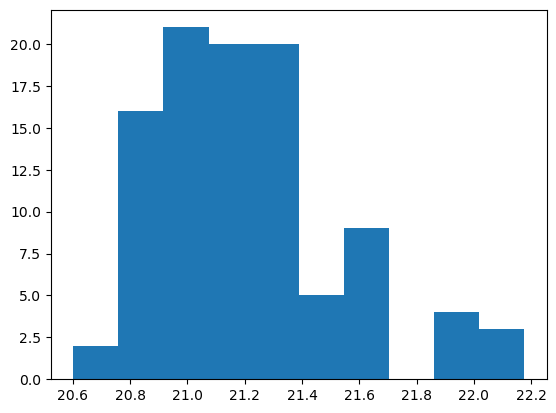

In [27]:
plt.hist(exps)

In [107]:
np.round(0.0003431, -3)

0.0

In [128]:
def find_rand_params(n_compounds:int, differentiate:int, n_compounds_per_well=0, n_wells=0, guesses=0, 
                     max_compounds=0, max_redundancy=4, min_redundancy=1):
    skip_compounds=True
    skip_wells=True
    if n_compounds_per_well==0:
        skip_compounds=False
    if n_wells==0:
        skip_wells=False
    if guesses==0:
        guesses=n_compounds

    MC= int(n_compounds/2) if max_compounds==0 else max_compounds
    mc=int(np.sqrt(n_compounds)) if int(np.sqrt(n_compounds))<MC else int(MC/2)
    arr_comp=np.arange(int(mc),int(MC+1))
    mw=int(0.75*np.sqrt(n_compounds))
    MW=int(2*np.sqrt(n_compounds))
    while MW-mw<10:
        mw=int(abs(mw-1))
        MW=int(MW+1)

    arr_wells=np.arange(mw,MW)
    min_tests=np.inf
    for comp in arr_comp:
        if skip_compounds:
            comp=n_compounds_per_well

        for wells in arr_wells:
            if skip_wells:
                if skip_compounds:
                    
                    return n_compounds_per_well, n_wells, assign_wells_random(n_compounds=n_compounds, differentiate=differentiate, 
                                               n_compounds_per_well=n_compounds_per_well, n_wells=n_wells, guesses=guesses, Evaluate=True)
                wells=n_wells
                
            if comp*wells>max_redundancy*n_compounds or comp*wells<min_redundancy*n_compounds: continue 
            WA_tmp, mean_exp=assign_wells_random(n_compounds, differentiate, comp, wells, guesses, Evaluate=True, return_me=True)
            if mean_exp<min_tests:
                Comp=comp
                Wells=wells
                min_tests=mean_exp
                min_wa=WA_tmp
            if skip_wells:
                break
        if skip_compounds:
            break

    return Comp, Wells, min_tests, min_wa

In [132]:
def assign_wells_random(n_compounds:int,  differentiate:int, n_compounds_per_well=0, n_wells=0, guesses=0, Evaluate=False, return_me=False, **kwargs)->np.array:
    if guesses==0:
        guesses=n_compounds
    min_tests=np.inf

    if n_compounds_per_well==0 or n_wells==0:
        _,_, min_tests, WA_rand=find_rand_params(n_compounds=n_compounds, differentiate=differentiate, 
                                 n_compounds_per_well=n_compounds_per_well, n_wells=n_wells, guesses=guesses)
        if return_me:
            return WA_rand,  min_tests
        
        return WA_rand
        


    if Evaluate:
        second_axis=np.tile(np.arange(n_wells),n_compounds_per_well).reshape(n_compounds_per_well,-1)
        for i in range(guesses):
            idt=np.random.randint(0,n_compounds,size=(n_compounds_per_well,n_wells) )
            well_assigner=np.zeros((n_compounds,n_wells))==1
            well_assigner[idt, second_axis]=True
            if guesses==1:
                if return_me:
                    mean_exp, _, _, p_check= mean_metrics(well_assigner, differentiate)
                    return well_assigner, mean_exp
                return well_assigner
            mean_exp, _, _, p_check= mean_metrics(well_assigner, differentiate)
            if p_check<1:
                if return_me:
                    return well_assigner,  mean_exp
                return well_assigner
            elif mean_exp<min_tests: 
                best_wa=well_assigner.copy()
                min_tests=mean_exp

        if return_me:
            return best_wa,  min_tests
        
        return best_wa

    _,_, min_tests, WA_rand=find_rand_params(n_compounds=n_compounds, differentiate=differentiate, 
                                 n_compounds_per_well=n_compounds_per_well, n_wells=n_wells, guesses=guesses)
    if return_me:
        return WA_rand,  min_tests
    
    return WA_rand
        
    


In [136]:
_=assign_wells_random(n_compounds=50,differentiate=4, n_compounds_per_well=8, n_wells=7, guesses=1, Evaluate=True, return_me=True)

In [126]:
def ab(a,b):
    return a,b

In [127]:
ab(ab(1,2),3)

((1, 2), 3)

In [120]:
c=assign_wells_random(n_compounds=25,differentiate=4)

In [138]:
WA=assign_wells_mat(130)

In [144]:
np.sum(WA, axis=0)

array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 10, 10])

In [142]:
tf, WAS, countss= is_consistent(WA, 2)
mean_metrics(WA, 2)

(23.803288314738698, 1.6712463199214915, 67.0)

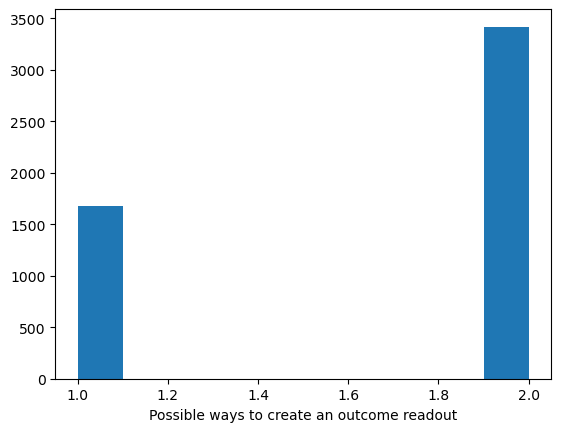

In [141]:
#Plot ambiguity
plt.hist(countss)
plt.xlabel('Possible ways to create an outcome readout')
plt.show()

In [7]:
# Select number of compounds and make the well assigner
NC=120
WA=assign_wells_L(NC,differentiate=2)

In [8]:
dff=2
#MT=mean_tests(WA, dff)
mean_exp, _, perc_check= mean_metrics(WA, dff)
print('To differentiate up to ', dff, 'positives requires on average ', np.round(mean_exp,2), 
      ' tests with a probability of ', perc_check, '% of needing two rounds of testing' )

To differentiate up to  2 positives requires on average  27.3  tests with a probability of  18.0 % of needing two rounds of testing


In [5]:
WA=assign_wells_random(NC,2, 20, 22,100)

In [6]:
dff=2
#MT=mean_tests(WA, dff)
mean_exp, _, perc_check= mean_metrics(WA, dff)
print('To differentiate up to ', dff, 'positives requires on average ', np.round(mean_exp,2), 
      ' tests with a probability of ', perc_check, '% of needing two rounds of testing' )


To differentiate up to  2 positives requires on average  22.61  tests with a probability of  14.0 % of needing two rounds of testing


In [59]:
#check shape for consistency
WA.shape

(120, 27)

In [60]:
#Print where a compound goes 
cp=np.random.randint(1,WA.shape[0]+1,1)
well_cp=from_compound_get_wells(cp,WA)
print('Compound', cp, 'needs to be in wells', well_cp)

Compound [88] needs to be in wells [12 13 22 24 26]


In [61]:
# Get all compounds for a well
wl=np.random.randint(1,WA.shape[1]+1,1)
cp_well=from_well_get_compuonds(wl,WA)
print('In well', wl, 'need to go compunds', cp_well)

In well [5] need to go compunds [  6  13  15  16  38  58  62  79  85  87 106 107 115 116]


In [62]:
# Check answer ambiguity
tf, WAS, countss= is_consistent(WA, 2)

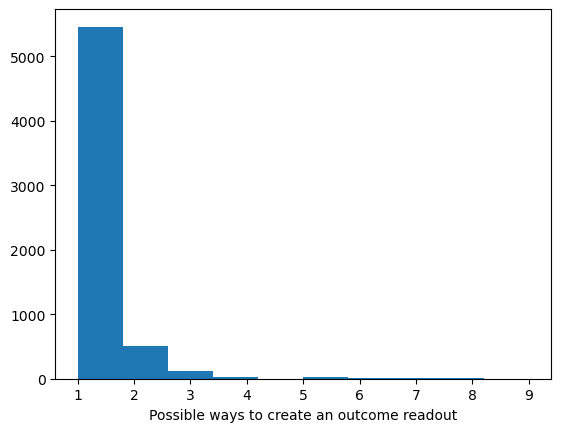

In [63]:
#Plot ambiguity
plt.hist(countss)
plt.xlabel('Possible ways to create an outcome readout')
plt.show()

In [66]:
avg_tst=avg_tests(countss)
print('with this assignment method on average ', np.round(avg_tst,2),'tests are needed')

with this assignment method on average  1.5 tests are needed


In [65]:
pr1=np.sum(countss[countss>1])/np.sum(countss)
#pr2=1-np.sum(countss[countss==1])/len(countss)
print('with this assignment method', np.round(pr1*100),'% of outcomes will lead to an ambiguous interpretation')

with this assignment method 25.0 % of outcomes will lead to an ambiguous interpretation


Do the same for the matrix like well construction

In [33]:
WAM=assign_wells_mat(120)

In [34]:
WAM.shape

(120, 22)

In [37]:
tf, WAT, countsm= is_consistent(WAM, 3)

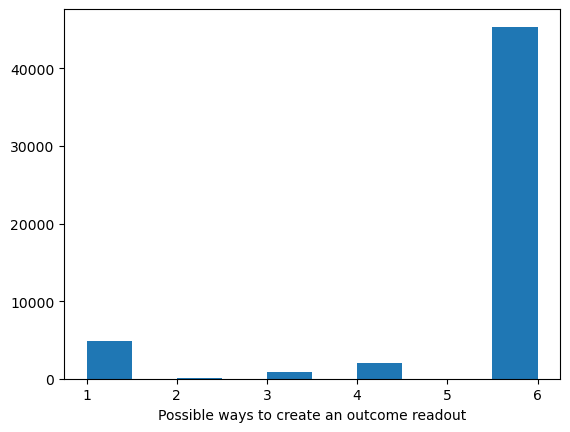

In [38]:
plt.hist(countsm)
plt.xlabel('Possible ways to create an outcome readout')
plt.show()

In [35]:
pr1=np.sum(countsm[countsm>1])/np.sum(countsm)
pr2=1-np.sum(countsm[countsm==1])/len(countsm)
print('with this assignment method from',np.round(pr2*100) ,'to', np.round(pr1*100),'% of outcomes will lead to an ambiguous interpretation')

with this assignment method from 67.0 to 81.0 % of outcomes will lead to an ambiguous interpretation


In [56]:
def assign_wells_multidim(n_compounds:int, n_dims:int)->np.array:
    L1=np.ceil(np.power(n_compounds, 1/n_dims))
    i=0
    while np.power(L1, n_dims-i-1)*np.power(L1-1, i+1)>n_compounds:
        i=i+1
    ls_dim=[L1]*(n_dims-i)+[L1-1]*i
    up_samps=np.prod(np.array(ls_dim))
    well_assigner=np.zeros((n_compounds, int(L1*(n_dims-i)+(L1-1)*i)))==1
    for j in range(n_compounds):
        cp_id=[]
        jj=np.copy(j)
        rem_dim=up_samps
        past_dims=0
        for k in range(n_dims):
            rem_dim=rem_dim/ls_dim[k]
            js=jj//rem_dim
            jj=jj-js*rem_dim
            jd=js+past_dims
            cp_id.append(int(jd))
            past_dims=past_dims+ls_dim[k]
        well_assigner[j,cp_id]=True
    return(well_assigner)

In [61]:
WA=assign_wells_multidim(8, n_dims=2)

In [62]:
WA

array([[ True, False, False,  True, False, False],
       [ True, False, False, False,  True, False],
       [ True, False, False, False, False,  True],
       [False,  True, False,  True, False, False],
       [False,  True, False, False,  True, False],
       [False,  True, False, False, False,  True],
       [False, False,  True,  True, False, False],
       [False, False,  True, False,  True, False]])

In [63]:
tf, WAS, countst= is_consistent(WA, 1)

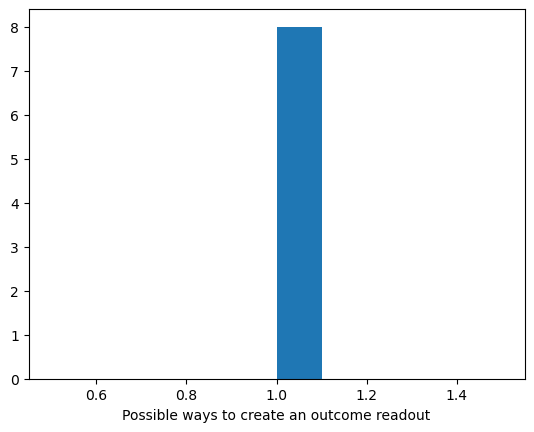

In [64]:
plt.hist(countst)
plt.xlabel('Possible ways to create an outcome readout')
plt.show()

In [ ]:
cp=np.random.randint(1,WA.shape[0]+1,1)
well_cp=from_compound_get_wells(cp,WA)
print('Compound', cp, 'needs to be in wells', well_cp)

In [ ]:
wl=np.random.randint(1,WA.shape[1]+1,1)
cp_well=from_well_get_compuonds(wl,WA)
print('In well', wl, 'need to go compunds', cp_well)

In [29]:
WA=assign_wells_STD(n_compounds=120, differentiate=1)

In [30]:
WA.shape

(120, 15)

In [31]:
tf, WASTD, countstd= is_consistent(WA, 1)

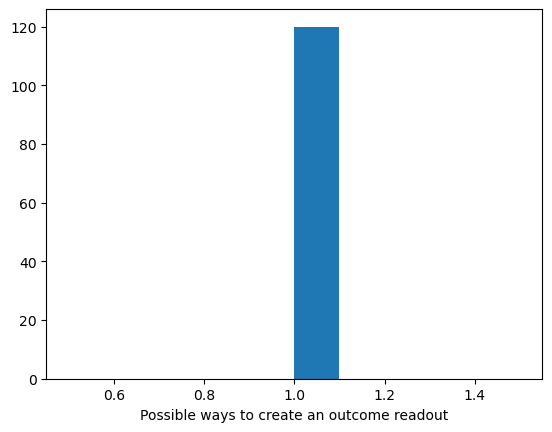

In [32]:
plt.hist(countstd)
plt.xlabel('Possible ways to create an outcome readout')
plt.show()

In [94]:
wl=np.random.randint(1,WA.shape[1]+1,1)
cp_well=from_well_get_compuonds(wl,WA)
print('In well', wl, 'need to go compunds', cp_well)

In well [2] need to go compunds [  2   7  12  17  22  27  32  37  42  47  52  57  62  67  72  77  82  87
  92  97 102 107 112 117]


In [326]:
# use the force_q argument to pass a known q, it will be used only if it satisfies the requirements
WA=assign_wells_STD(n_compounds=120, differentiate=1, force_q=11)

In [327]:
tf, WASTD, countstd= is_consistent(WA, 2)

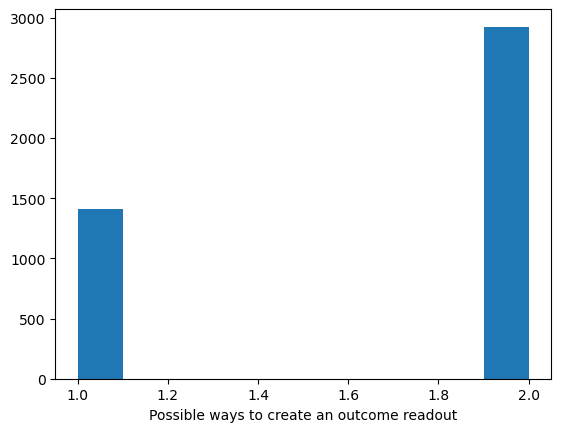

In [328]:
plt.hist(countstd)
plt.xlabel('Possible ways to create an outcome readout')
plt.show()

In [330]:
rw=np.random.randint(WASTD.shape[0])
res=WASTD[rw,:]#.reshape(1,-1)

decoded=decode(WA,res,2)

print('The possible compounds to be active are', decoded)

The possible compounds to be active are [(5, 67), (84, 117)]
